# Extract breathing rate and crop windows

**Note** <br>
If this is your first time running this code, you probably need to install the **neurokit2** library

Before proceeding, make sure your Python environment is activated (e.g. `venv`).  
Once the environment is active, install the required dependency by running:

```console
pip install neurokit2
```

In [10]:
# Library
import os
import numpy as np
import pandas as pd
import math
import neurokit2 as nk
import matplotlib.pyplot as plt

# General info
base_folder = '../datasets'
result_folder = '../Datasets_cropped'
cut_window = 20 # seconds > 20s
overlap = 0 # percentage %
cut_before = 20 # seconds
cut_after = 20 # seconds

# Radar info
radar_folder = 'SR250Mate'
radar_frequency = 10


# Breathing info
breathing_folder = 'Breathing'
breathing_frequency = 10

In [11]:
radar_path = os.path.join(base_folder,radar_folder)
breathing_path = os.path.join(base_folder,breathing_folder)

result_radar_path = os.path.join(result_folder,radar_folder)

if not os.path.exists(result_folder):
    os.mkdir(result_folder)

if not os.path.exists(result_radar_path):
    os.mkdir(result_radar_path)

radar_files = []
for name_file in os.listdir(radar_path):
    if name_file.endswith(".npy"):
        radar_files.append(name_file)

breathing_files = []
for name_file in os.listdir(breathing_path):
    if name_file.endswith(".csv"):
        breathing_files.append(name_file)

AVG Breathing rate: 13.56 Bpm


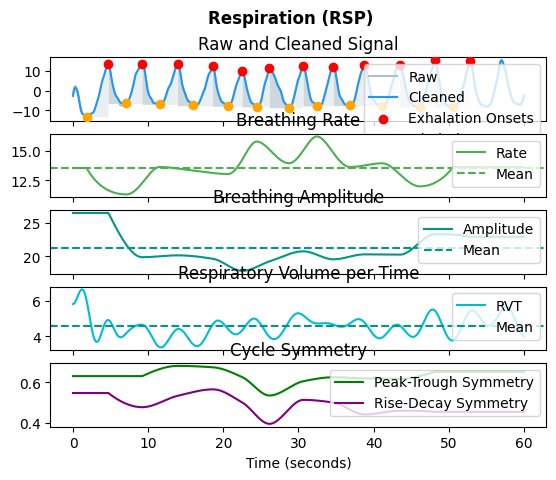

AVG Breathing rate: 13.56 Bpm


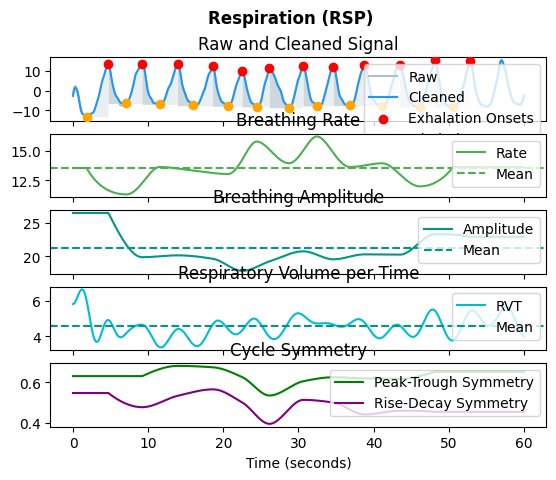

AVG Breathing rate: 13.56 Bpm


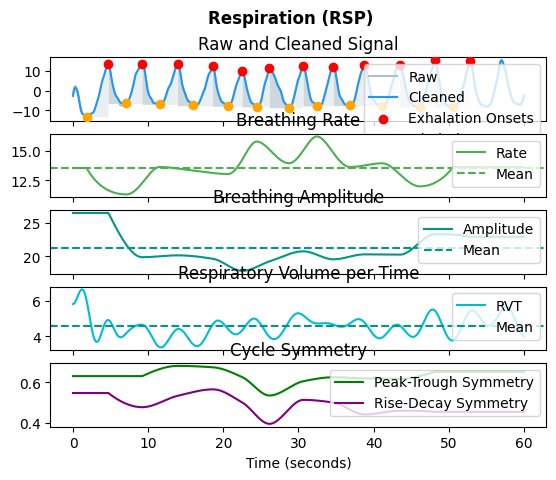

In [12]:
def find_breathing_file(sub_file_path):
    temp_path = None
    for file in breathing_files:
        if file.startswith(sub_file_path):
            temp_path = file
            break
    return os.path.join(breathing_path,temp_path)

def get_rate_breathing(data):
    rsp_cleaned = nk.rsp_clean(data, sampling_rate=breathing_frequency)
    rate = nk.rsp_rate(rsp_cleaned, sampling_rate=breathing_frequency)
    signals, info = nk.rsp_process(rsp_cleaned, sampling_rate=breathing_frequency)

    print(f"AVG Breathing rate: {rate.mean():.2f} Bpm")
    nk.rsp_plot(signals, info=info)
    plt.show()
    
    return rate

for file in radar_files:
    file_path_radar = os.path.join(radar_path,file)
    labels = file.split('_')
    time, date = labels[3].split('-')

    sub1 = "_".join(labels[:3]) + "_"
    sub2 = "_" + "_".join(labels[4:-1]) + "_"
    antenna = labels[-1][:-4]

    # Get corresponding breathing path
    sub_name = "_".join(labels[:4]) + "_"
    file_path_gt = find_breathing_file(sub_name)

    # Load radar data
    array_radar = np.load(file_path_radar)
    array_radar = array_radar[(cut_before * radar_frequency):-((cut_after + 1)*radar_frequency)]

    # Load breathing data
    array_breathing = pd.read_csv(file_path_gt)["force"].values
    rates = get_rate_breathing(array_breathing)
    rates = rates[(cut_before * breathing_frequency):-(cut_after*breathing_frequency)]
    
    log_duration = len(array_radar)/radar_frequency

    windows = math.floor((log_duration-cut_window)/(cut_window * (1 - (overlap / 100)))) + 1

    for i in range(windows):
        # Cut radar
        start_radar = i * int(cut_window * radar_frequency * (1 - (overlap/100)))
        end_radar = start_radar + int(cut_window * radar_frequency)
        data_radar = array_radar[start_radar:end_radar]

        # Cut Breathing + rate
        start_breathing = i * int(cut_window * breathing_frequency * (1 - (overlap/100)))
        end_breathing = start_breathing + int(cut_window * breathing_frequency)
        rate = rates[start_breathing:end_breathing].mean()
        
        # Setup cutted file
        save_time = str(int(time)+cut_before+(i * int(cut_window * (1 - (overlap/100)))))
        temp_path = sub1 + save_time + "-" + str(date) + sub2 + str(f"{rate:.2f}") + "_" + antenna + ".npy"
        file_cutted_path = os.path.join(result_radar_path,temp_path)
        np.save(file_cutted_path, data_radar)